# Лекция 7. Линейные модели для классификации

In [137]:
#pip install mlxtend

In [138]:
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

## Логистическая регрессия

Теория: 
* Python_i_mashinnoe_obuchenie: с. 74-82 
* ESLII_print12: с. 119-129, 161, 299-304, 657
* https://habr.com/ru/company/io/blog/265007/
* https://habr.com/ru/post/485872/
* Logistic Regression Tutorial for Machine Learning: https://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/
* Logistic Regression for Machine Learning: https://machinelearningmastery.com/logistic-regression-for-machine-learning/
* Logistic Regression in Python: https://realpython.com/logistic-regression-python/
* https://medium.com/@annalienk/regularised-logistic-regression-8d8d86034fb3

Рассмотрим список из трех потенциальных заемщиков.

In [139]:
r = 25000.0
w_0 = -5000.0/r
w_1 = 1.0/r
w_2 = -3.0/r

data = {'The borrower':np.array(['Vasya', 'Fedya', 'Lesha']), 
        'Salary':np.array([120000,180000,210000]),
       'Payment':np.array([3000,50000,70000])}

df = pd.DataFrame(data)

df['y'] = w_0 + df['Salary']*w_1 + df['Payment']*w_2

decision = []
for i in df['y']:
    if i > 0:
        dec = 'Approved'
        decision.append(dec)
    else:
        dec = 'Refusal'
        decision.append(dec)
        
df['Decision'] = decision

df[['The borrower', 'Salary', 'Payment', 'y', 'Decision']]

,The borrower,Salary,Payment,y,Decision
0,Vasya,120000,3000,4.24,Approved
1,Fedya,180000,50000,1.00,Approved
2,Lesha,210000,70000,-0.20,Refusal


В соответствии с данными таблицы, Вася при зарплате в 120 000Р хочет получить такой кредит, чтобы ежемесячного гасить его по 3 000Р. Нами было определено, что для одобрения кредита, размер заработной платы Васи должен превышать в три раза размер платежа, и чтобы еще оставалось 5 000Р. Этому требованию Вася удовлетворяет. Остается даже 106 000Р. Несмотря на то, что при расчете мы уменьшили коэффициенты в 25 000 раз, результат получили тот же — кредит может быть одобрен. Федя тоже получит кредит, а вот Леше, несмотря на то, что он получает больше всех, придется поумерить свои аппетиты.

Нарисуем график классификации заемщиков.

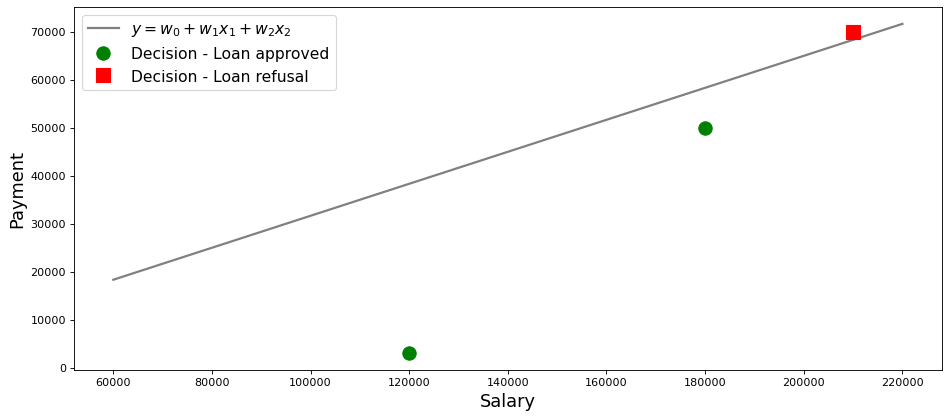

In [140]:
salary = np.arange(60000,240000,20000)
payment = (-w_0-w_1*salary)/w_2


fig, axes = plt.subplots(figsize = (14,6), dpi = 80)
plt.plot(salary, payment, color = 'grey', lw = 2, label = '$y=w_0 + w_1x_1 + w_2x_2$')
plt.plot(df[df['Decision'] == 'Approved']['Salary'], df[df['Decision'] == 'Approved']['Payment'], 
         'o', color ='green', markersize = 12, label = 'Decision - Loan approved')
plt.plot(df[df['Decision'] == 'Refusal']['Salary'], df[df['Decision'] == 'Refusal']['Payment'], 
         's', color = 'red', markersize = 12, label = 'Decision - Loan refusal')
plt.xlabel('Salary', size = 16)
plt.ylabel('Payment', size = 16)
plt.legend(prop = {'size': 14})
plt.show()

Обобщим выводы из этого простенького примера. Возьмем точку $M(x_1,x_2)$ и, подставляя координаты точки в соответствующее уравнение прямой $y=w_0+w_1*x_1+w_2*x_2$, рассмотрим три варианта:

1. Если точка находится под прямой, и мы относим ее к классу +1, то значение функции $y=w_0+w_1*x_1+w_2*x_2$ будет положительным от 0 до +$\infty$. Значит, мы можем считать, что вероятность погашения кредита, находится в пределах (0.5;1]. Чем больше значение функции, тем выше вероятность.

2. Если точка находится над прямой и мы относим ее к классу -1 или 0, то значение функции будет отрицательным от -$\infty$ до 0. Тогда мы будем считать, что вероятность погашения задолженности находится в пределах [0;0.5) и, чем больше по модулю значение функции, тем выше наша уверенность.

3. Точка находится на прямой, на границе между двумя классами. В таком случае значение функции $y=w_0+w_1*x_1+w_2*x_2$ будет равно 0, и вероятность погашения кредита равна 0.5.

Функция логистического отклика:

$p_+=\frac{1}{1+\exp(-y)}=\sigma(y)$

Посмотрим на график функции логистического отклика.

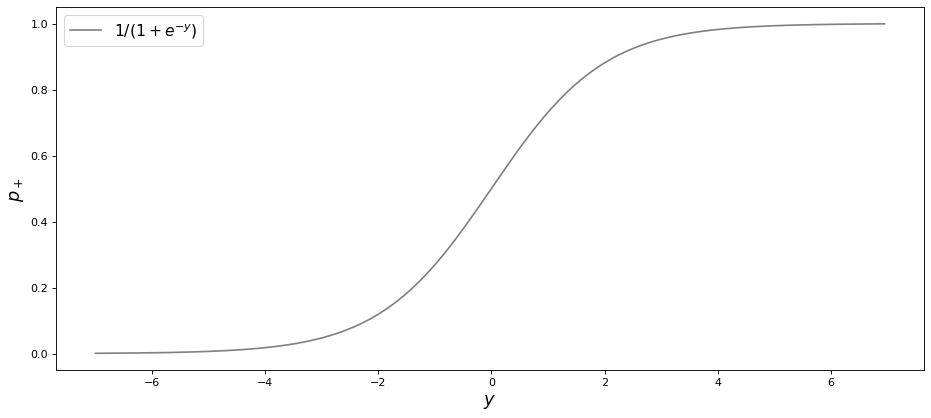

In [141]:
def logit (f):
    return 1/(1+math.exp(-f))

f = np.arange(-7,7,0.05)
p = []

for i in f:
    p.append(logit(i))

fig, axes = plt.subplots(figsize = (14,6), dpi = 80)
plt.plot(f, p, color = 'grey', label = '$ 1 / (1+e^{-y})$')
plt.xlabel('$y$', size = 16)
plt.ylabel('$p_+$', size = 16)
plt.legend(prop = {'size': 14})
plt.show()

Вернемся к нашему кредитному аналитику и поможем ему с вычислением вероятности погашения кредитов.

In [142]:
r = 25000.0
w_0 = -5000.0/r
w_1 = 1.0/r
w_2 = -3.0/r

data = {'The borrower':np.array(['Vasya', 'Fedya', 'Lesha']), 
        'Salary':np.array([120000,180000,210000]),
       'Payment':np.array([3000,50000,70000])}

df = pd.DataFrame(data)

df['y'] = w_0 + df['Salary']*w_1 + df['Payment']*w_2

decision = []
for i in df['y']:
    if i > 0:
        dec = 'Approved'
        decision.append(dec)
    else:
        dec = 'Refusal'
        decision.append(dec)
        
df['Decision'] = decision

proba = []
for i in df['y']:
    proba.append(round(logit(i),2))
    
df['Probability'] = proba

df[['The borrower', 'Salary', 'Payment', 'y', 'Decision', 'Probability']]

,The borrower,Salary,Payment,y,Decision,Probability
0,Vasya,120000,3000,4.24,Approved,0.99
1,Fedya,180000,50000,1.00,Approved,0.73
2,Lesha,210000,70000,-0.20,Refusal,0.45


Итак, вероятность возврата кредита мы определили. В целом, это похоже на правду.

### Реализация метода логистической регрессии в Python

Метод LogisticRegression реализован в библиотеке scikit-learn в классе sklearn.linear_model.logistic.

Используя бинарный классификатор для каждого класса, мы получаем один вектор коэффициентов (w) и одну константу (b) по каждому классу. Класс, который получает наибольшее значение регрессии, составленной из признаков, их весов и константы, становится присвоенной меткой класса.

Загрузим набор данных по ирисам, который включен в модуль datasets библиотеки (пакета) sklearn, вызвав функцию load_iris():

In [143]:
iris_dataset = load_iris()

In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    iris_dataset['data'], iris_dataset['target'], random_state=0)

Теперь обучаем на этом наборе данных классификатор класса sklearn.linear_model.logistic.

In [145]:
logreg=LogisticRegression(max_iter=1000)

In [146]:
lofreg_fit = logreg.fit(X_train, y_train)
print("Форма коэффициента: ", lofreg_fit.coef_.shape)
print("Форма константы: ", lofreg_fit.intercept_.shape)

Форма коэффициента:  (3, 4)
Форма константы:  (3,)


In [147]:
print("Правильность на обучающем наборе: {:.2f}".format(lofreg_fit.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(lofreg_fit.score(X_test, y_test)))

Правильность на обучающем наборе: 0.98
Правильность на тестовом наборе: 0.97


In [148]:
#Зададим параметры некоторого ириса, сорт которого мы хотим узнать.
X_new = np.array([[5, 2.9, 1, 0.2]])
print("Форма массива X_new:", X_new.shape)

Форма массива X_new: (1, 4)


Теперь мы можем получить прогнозы, применив эту модель к новым данным, по которым мы еще не знаем правильные метки.

In [149]:
prediction = lofreg_fit.predict(X_new)
print("Прогноз:", prediction)
print("Спрогнозированная метка:",
       iris_dataset['target_names'][prediction])

Прогноз: [0]
Спрогнозированная метка: ['setosa']


## Линейный метод опорных векторов (linear support vector machines), или линейный SVM

Теория: 
* Python_i_mashinnoe_obuchenie: с. 85-89 (!)
* ESLII_print12: с. 423-438

Метод SVM реализован в библиотеке scikit-learn в классе svm.LinearSVC [см. Андревс Мюллер, Сара Гвидо. Введение в машинное обучение с помощью PYTHON. Руководство для специалистов по работе с данными].
Здесь SVC расшифровывается как support vector classifier - классификактор опорных векторов.

Используя бинарный классификатор для каждого класса, мы получаем один вектор коэффициентов (w) и одну константу (b) по каждому классу. Класс, который получает наибольшее значение линейной регрессии, составленной из признаков, их весов и константы, становится присвоенной меткой класса.

Вид линейной регрессии для каждого класса:
$\hat{y}=w_1x_1+w_2x_2+⋯+w_kx_k+b$

Загрузим набор данных по ирисам, который включен в модуль datasets библиотеки (пакета) sklearn, вызвав функцию load_iris():

In [150]:
iris_dataset = load_iris()

In [151]:
X_train, X_test, y_train, y_test = train_test_split(
    iris_dataset['data'], iris_dataset['target'], random_state=0)

Теперь обучаем на этом наборе данных классификатор класса LinearSVC.

In [152]:
linear_svm = LinearSVC().fit(X_train, y_train)
print("Форма коэффициента: ", linear_svm.coef_.shape)
print("Форма константы: ", linear_svm.intercept_.shape)

Форма коэффициента:  (3, 4)
Форма константы:  (3,)


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [153]:
print("Правильность на обучающем наборе: {:.2f}".format(linear_svm.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.2f}".format(linear_svm.score(X_test, y_test)))

Правильность на обучающем наборе: 0.98
Правильность на тестовом наборе: 0.92


Теперь мы можем получить прогнозы, применив эту модель к новым данным, по которым мы еще не знаем правильные метки.

In [154]:
#Зададим параметры некоторого ириса, сорт которого мы хотим узнать.
X_new = np.array([[5, 2.9, 1, 0.2]])
print("Форма массива X_new:", X_new.shape)

Форма массива X_new: (1, 4)


Чтобы сделать прогноз, вызываем метод predict объекта svm.

In [155]:
prediction = linear_svm.predict(X_new)
print("Прогноз:", prediction)
print("Спрогнозированная метка:",
       iris_dataset['target_names'][prediction])

Прогноз: [0]
Спрогнозированная метка: ['setosa']


## Линейный дискриминантный анализ (lineaг discгiminant analysis, LDA)

Теория: 
* Python_i_mashinnoe_obuchenie: с. 144-151 
* ESLII_print12: с. 106-119 (!)
* https://machinelearningmastery.com/linear-discriminant-analysis-for-machine-learning/
* http://statsoft.ru/home/textbook/modules/stdiscan.html

Подробней о теореме Байеса в машинном обучении смотри: https://machinelearningmastery.com/bayes-theorem-for-machine-learning/

Переход от формулы Байеса к линейной дискриминантной функции смотри в книге ESLII_print12: с. 106-119

Линейная дискриминантная функция для класса $k$ и наблюдений $x$ имеет следующий вид:

$D_k(x)=x*\frac{m_k}{\sigma^2}-\frac{m_k^2}{2*\sigma^2} + \ln(p_k)$

## Реализация линейного дискриминантного анализа в Python

Чтение данных

In [156]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<hr>

### Note:


If the link to the Wine dataset provided above does not work for you, you can find a local copy in this repository at [./../datasets/wine/wine.data](./../datasets/wine/wine.data).

Or you could fetch it via



In [157]:
df_wine = pd.read_csv('https://raw.githubusercontent.com/rasbt/python-machine-learning-book/master/code/datasets/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
'Alcalinity of ash', 'Magnesium', 'Total phenols', 
'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 
'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<hr>

Разделим выборку на обучающий (70%) и тестовый набор (30%).

In [158]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

Стандартизируем признаки набора данных сортов вин.

In [159]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## Вычисление матриц разброса

Вычислим вектор средних для кажого класса:

In [160]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



Используя векторы средних, теперь можно вычислить матрицу разброса точек
внутри класса $S_W$:

In [161]:
d = 13  # число признаков
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # матрица разброса для каждого класса
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # сделать векторы из столбцов
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                # просуммировать матрицы разброса для классов

print('Внутриклассовая матрица разброса: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Внутриклассовая матрица разброса: 13x13


Во время вычисления матриц разброса мы делаем допущение, что метки классов
в тренировочном наборе равномерно распределены. Однако если распечатать число
меток классов, то увидим, что это допущение нарушено:

In [162]:
print('Распределение меток классов: %s' 
      % np.bincount(y_train)[1:])

Распределение меток классов: [40 49 35]


Вследствие этого мы хотим прошкалировать индивидуальные матрицы разброса
$S_i$, прежде чем просуммируем их как матрицу разброса $S_W$. Во время разбивки матрицы
разброса на число образцов классов $N_i$ можно увидеть, что вычисление матрицы
разброса фактически не отличается от вычисления ковариационной матрицы $\sum_i$.
Ковариационная матрица - это нормализованная версия матрицы разброса:

In [163]:
d = 13  # число признаков
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Масштабированная внутриклассовая матрица разброса: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Масштабированная внутриклассовая матрица разброса: 13x13


Вычислив масштабированную матрицу разброса внутри классов (или ковариационную
матрицу), можно перейти к следующему шагу и вычислить матрицу разброса
между классами $S_B$ :

In [164]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # число признаков
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Межклассовая матрица разброса: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Межклассовая матрица разброса: 13x13


## Отбор линейных дискриминантов для нового подпространства признаков

Решим обобщенную задачу на собственные значения матрицы $S_W^{-1}S_B$:

In [165]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

**Note**:
    
Above, I used the [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) function to decompose the symmetric covariance matrix into its eigenvalues and eigenvectors.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    This is not really a "mistake," but probably suboptimal. It would be better to use [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) in such cases, which has been designed for [Hermetian matrices](https://en.wikipedia.org/wiki/Hermitian_matrix). The latter always returns real  eigenvalues; whereas the numerically less stable `np.linalg.eig` can decompose nonsymmetric square matrices, you may find that it returns complex eigenvalues in certain cases. (S.R.)


После того как мы вычислили собственные пары, теперь можно отсортировать
собственные значения в убывающем порядке:

In [166]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Собственные значения в убывающем порядке:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Собственные значения в убывающем порядке:

452.72158124497435
156.43636121952318
7.769104774368976e-14
5.2326819352017985e-14
2.842170943040401e-14
2.4807080973455738e-14
1.837435550858223e-14
1.837435550858223e-14
1.731480632966931e-14
9.9214658168895e-15
9.9214658168895e-15
2.8144369121263053e-15
2.8144369121263053e-15


В LDA число линейных дискриминантов не превышает с - 1, где с - это число
меток классов, поскольку матрица разброса между классами $S_B$ является суммой
матриц с с рангом 1 или меньше. Мы, действительно, видим, что у нас всего два не нулевых собственных значения (собственные значения 3-13 не равны строго нулю,
но это происходит в силу арифметики с плавающей точкой в NumPy). Отметим , что
в редком случае полной коллинеарности (все точки образцов выровнены вдоль прямой) ковариационная матрица будет с рангом 1, что приведет к образованию всего
одного собственного вектора с ненулевым собственным значением.

Чтобы измерить, сколько информации о различении классов захвачено линейными
дискриминантами (собственными векторами), построим график линейных дискриминантов
по убыванию собственных значений. Для простоты назовем содержание
информации о различении классов дискриминабельностью.

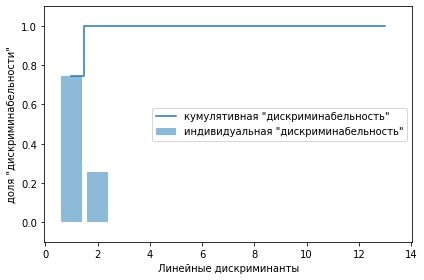

In [167]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='индивидуальная "дискриминабельность"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='кумулятивная "дискриминабельность"')
plt.ylabel('доля "дискриминабельности"')
plt.xlabel('Линейные дискриминанты')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/lda1.png', dpi=300)
plt.show()

Как видно на итоговом рисунке, первые два линейных дискриминанта захватывают
в тренировочном наборе данных сортов вин примерно 100% полезной информации.

Теперь объединим вертикально два наиболее отличительных столбца с собственными
векторами, чтобы создать матрицу преобразования W:

In [168]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Матрица W:\n', w)

Матрица W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


## Проецирование образцов на новое пространство признаков

При помощи матрицы преобразования W, которую мы создали в предыдущем подразделе, теперь можно преобразовать тренировочный набор данных путем умножения матриц: 
* Х' = XW.

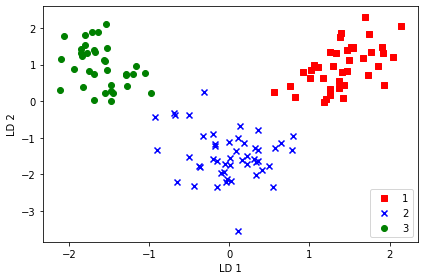

In [169]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0] * (-1),
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/lda2.png', dpi=300)
plt.show()

Как видно на получившемся графике, теперь в новом подпространстве признаков
три класса вин линейно разделимы.

## Метод LDA в scikit-learn

Пошаговая реализация была хорошим упражнением для понимания внутреннего
устройства LDA. Теперь рассмотрим класс под названием LDA, реализованный в библиотеке scikit- leaгn:

In [170]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

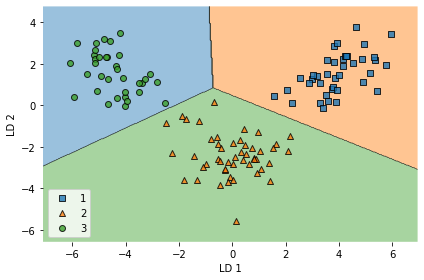

In [171]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, clf=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda3.png', dpi=300)
plt.show()

Рассматривая итоговый график, видно, что модель логистической регрессии неправильно
классифицирует одну из образцов из класса 2.

Понизив силу регуляризации, по-видимому, можно было бы сместить границы
решения, в результате чего модели логистической регрессии будут правильно классифицировать все образцы в тренировочном наборе данных. Впрочем, проанализируем
результаты на тестовом наборе:

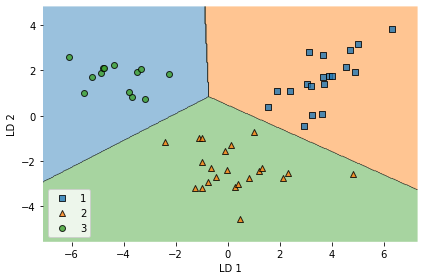

In [172]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, clf=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda4.png', dpi=300)
plt.show()

Как видно на получившемся графике, классификатор на основе логистической
регрессии в состоянии получить идеальную оценку верности классификации образцов
на тестовом наборе данных, используя для этого всего лишь двумерное подпространство
признаков вместо исходного набора с 13 признаками вин.